In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./kaggle/input'):
#for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./kaggle/input/Kannada-MNIST/train.csv
./kaggle/input/Kannada-MNIST/sample_submission.csv
./kaggle/input/Kannada-MNIST/test.csv
./kaggle/input/Kannada-MNIST/Dig-MNIST.csv


# Imports - loading the data

I used this notebook:
https://www.kaggle.com/code/gabmars/pytorch-lenet5

In [2]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torchmetrics
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device) # Might as well find out! 

/home/szekeres/anaconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [3]:
train_data = pd.read_csv('./kaggle/input/Kannada-MNIST/train.csv')

In [4]:
train_data.shape

(60000, 785)

In [5]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train_data = train_data.sample(frac=1,random_state=32).reset_index(drop=True)

In [7]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# split the data into features and target label
X, y = (train_data.drop(['label'], axis=1), train_data.label)

In [9]:
class KannadaDataSet(torch.utils.data.Dataset):
    def __init__(self, images, labels, transforms = None):
        self.images = images
        self.labels = labels
        self.transforms = transforms
         
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, i):
        data = np.array(self.images.iloc[i,:]).astype(np.uint8).reshape(28,28,1)
        
        if self.transforms:
            data = self.transforms(data)
            
        return (data, self.labels[i])

In [10]:
transform = transforms.Compose(([
    transforms.ToTensor(),
]))

In [11]:
X.shape, y.shape, type(X)

((60000, 784), (60000,), pandas.core.frame.DataFrame)

In [12]:
X[1000:2000]

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
learn_num = int(len(X)*0.75)

In [14]:
train_set = KannadaDataSet(X[:learn_num], y[:learn_num], transform)
valid_set = KannadaDataSet(X[learn_num:].reset_index(drop=True), y[learn_num:].reset_index(drop=True), transform)

In [15]:
torch.manual_seed(43)
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100, 
                                           shuffle=False)

valid_loader = torch.utils.data.DataLoader(valid_set,
                                          batch_size=100, 
                                          shuffle=False)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

tensor([3, 1, 1, 3, 3, 7, 5, 4, 9, 8, 8, 8, 8, 9, 3, 9, 7, 3, 3, 5, 3, 1, 6, 8,
        9, 9, 4, 9, 0, 0, 4, 8, 4, 2, 8, 8, 8, 5, 8, 9, 4, 7, 8, 5, 9, 8, 2, 0,
        6, 0, 5, 4, 1, 4, 3, 4, 7, 8, 5, 7, 6, 3, 0, 8, 2, 3, 2, 1, 7, 0, 1, 5,
        9, 4, 7, 3, 8, 6, 6, 4, 3, 7, 9, 2, 4, 1, 7, 0, 9, 3, 4, 4, 8, 1, 3, 0,
        4, 5, 0, 1])


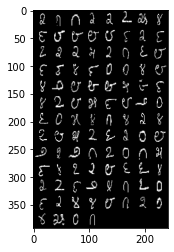

In [16]:
images, labels = next(iter(train_loader))
plt.imshow(torchvision.utils.make_grid(images)[0,:,:], cmap='gray')
print(labels)

# Baseline model

I used https://www.kaggle.com/code/gabmars/pytorch-lenet5 here again.

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, 
                               out_channels=12, 
                               kernel_size=5, 
                               padding=0)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, 
                               out_channels=32, 
                               kernel_size=3, 
                               padding=0)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 5 * 5, 240)
        self.fc2 = nn.Linear(240, 168)
        self.fc3 = nn.Linear(168, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        #x = F.max_pool2d(x,2)
        x = F.avg_pool2d(x,2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        #x = F.max_pool2d(x,2)
        x = F.avg_pool2d(x,2)
        x = x.view(-1, 32 * 5 * 5)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def features_2(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
#         x = F.max_pool2d(F.relu(self.conv1(x)),2)
#         x = F.max_pool2d(F.relu(self.conv2(x)),2)
        return x
    
    def features_1(self, x):
        x = F.relu(self.conv1(x))
#         x = F.max_pool2d(F.relu(self.conv1(x)),2)
        return x

In [18]:
def train(train_loader,valid_loader,model,optimizer,criterion,num_epochs=10,lr_scheduler=None):
    """
    Function for training
    
    train_loader : training dataset loader
    valid_loader : validation dataset loader
    optimizer : optimizer algorithm
    criterion : loss function
    num_epochs : number of epochs
    
    The function returns (train_loss_list, train_acc_list, valid_loss_list, valid_acc_list), where
    train_loss_list : average loss on mini-batches in the training set
    train_acc_list : training accuracy
    valid_loss_list : average loss on mini-batches in the validation set
    valid_acc_list : average validation accuracy
    """
    
    train_loss_list = []
    valid_loss_list = []
    train_acc_list = []
    valid_acc_list = []

    epoch = 0
    while epoch < num_epochs:
        epoch+=1
            
        train_loss_temp = []
        train_acc_temp = 0.0
        train_total_samples = 0
    
        # training phase
        for i, data in enumerate(train_loader, 0):

            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # training loss
            train_loss_temp.append(loss.item())
        
            # training accuracy
            _, predicted = torch.max(outputs.data, 1)
            train_acc_temp += (predicted == labels).sum().item()
            train_total_samples += labels.size(0)
        
        train_loss_list.append(np.mean(train_loss_temp))
        train_acc_list.append(train_acc_temp/train_total_samples)
    
        # validation set
        with torch.no_grad():
            valid_loss_temp = []
            valid_acc_temp = 0.0
            valid_total_samples = 0
            model.eval()
        
            for v_i, v_data in enumerate(valid_loader,0):
                v_inputs, v_labels = v_data[0].to(device), v_data[1].to(device)
                v_outputs = model(v_inputs)
                v_loss = criterion(v_outputs,v_labels)
            
                valid_loss_temp.append(v_loss.item())
                _, predicted = torch.max(v_outputs.data,1)
                
            
                valid_total_samples += v_labels.size(0)
                valid_acc_temp += (predicted == v_labels).sum().item()
            
            valid_loss_list.append(np.mean(valid_loss_temp))
            valid_acc_list.append(valid_acc_temp/valid_total_samples)

        model.train()   
        
        # Scheduler
        if lr_scheduler:
            lr_scheduler.step()
    
        # Displaying the results
        print(f"[{epoch}/{num_epochs}] | TE: {train_loss_list[-1]:.6f} TA: {train_acc_list[-1]:.6f} | VE {valid_loss_list[-1]:.6f} VA: {valid_acc_list[-1]:.6f}")

    return train_loss_list, train_acc_list, valid_loss_list, valid_acc_list

In [19]:
def plot_acc_loss(valid_acc_list,valid_loss_list):
    """
    Plotting function
    
    valid_acc_list : validation accuracies in a list (by epochs)
    valid_loss_list : validation losses in a list (by epochs)
    """
    
    fig, ax = plt.subplots(1, 2, figsize = (8, 4))

    ax[0].set_title('Validation accuracy')
    ax[0].plot(valid_acc_list, color = 'blue', label = 'baseline')
    #ax[0].set_ylim(0.1, 1.0)
    #ax[0].legend()

    ax[1].set_title('Validation loss')
    ax[1].plot(valid_loss_list, color = 'green', label = 'baseline')
    #ax[1].plot(bn_val_accs, color = 'red', label = 'modified')
    #ax[1].legend()

    plt.show() 

In [20]:
torch.manual_seed(42)
net = Net().to(device)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=5e-3, momentum=0.9)

In [ ]:
summary(net, input_size = (1, 28, 28), device = 'cuda')

In [ ]:
# https://discuss.pytorch.org/t/how-to-do-exponential-learning-rate-decay-in-pytorch/63146
decayRate = 0.96
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

In [22]:
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = train(train_loader,valid_loader,net,optimizer,criterion,100,lr_scheduler)

[1/10] | TE: 1.476520 TA: 0.734422 | VE 0.465531 VA: 0.916067
[2/10] | TE: 0.270564 TA: 0.939800 | VE 0.184693 VA: 0.954600
[3/10] | TE: 0.141670 TA: 0.963622 | VE 0.122030 VA: 0.967867
[4/10] | TE: 0.099873 TA: 0.973378 | VE 0.093209 VA: 0.975267
[5/10] | TE: 0.078413 TA: 0.978622 | VE 0.076734 VA: 0.979933
[6/10] | TE: 0.065568 TA: 0.982178 | VE 0.066247 VA: 0.982333
[7/10] | TE: 0.057097 TA: 0.984311 | VE 0.058999 VA: 0.983800
[8/10] | TE: 0.051050 TA: 0.986111 | VE 0.053687 VA: 0.985200
[9/10] | TE: 0.046464 TA: 0.987311 | VE 0.049561 VA: 0.986400
[10/10] | TE: 0.042811 TA: 0.988067 | VE 0.046239 VA: 0.986933


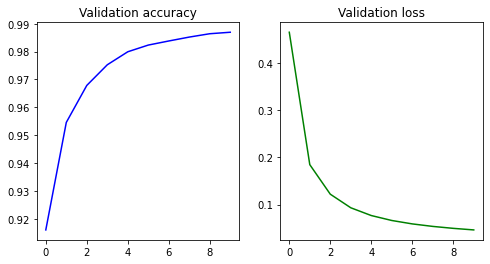

In [23]:
plot_acc_loss(valid_acc_list,valid_loss_list)

In [25]:
torch.manual_seed(42)
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=2.5e-4)

In [ ]:
summary(net, input_size = (1, 28, 28), device = 'cuda')

In [26]:
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = train(train_loader,valid_loader,net,optimizer,criterion,10)

[1/10] | TE: 0.124185 TA: 0.967533 | VE 0.050145 VA: 0.986000
[2/10] | TE: 0.031229 TA: 0.990378 | VE 0.035000 VA: 0.990200
[3/10] | TE: 0.022423 TA: 0.992800 | VE 0.032519 VA: 0.990600
[4/10] | TE: 0.017728 TA: 0.994533 | VE 0.028261 VA: 0.991467
[5/10] | TE: 0.014254 TA: 0.995756 | VE 0.021001 VA: 0.993867
[6/10] | TE: 0.011876 TA: 0.996511 | VE 0.024510 VA: 0.993000
[7/10] | TE: 0.012217 TA: 0.996067 | VE 0.023959 VA: 0.992867
[8/10] | TE: 0.009161 TA: 0.997089 | VE 0.027033 VA: 0.993000
[9/10] | TE: 0.006274 TA: 0.998200 | VE 0.026610 VA: 0.993533
[10/10] | TE: 0.009438 TA: 0.997044 | VE 0.028082 VA: 0.993000


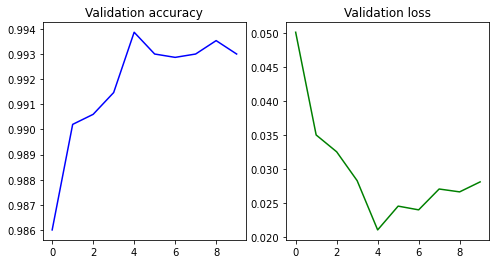

In [27]:
plot_acc_loss(valid_acc_list,valid_loss_list)

# ResNetV2

Stolen from deep learning practice (it was a homework).

In [28]:
class BasicBlock(nn.Module):

    def __init__(self, in_channel_size = 16, out_channel_size = 16, downsample = False):
        super().__init__()
        self.conv1 = nn.Conv2d(
                        in_channels = in_channel_size,
                        out_channels = out_channel_size,
                        kernel_size = 3,
                        stride = 2 if downsample else 1,
                        padding = 1
                        )
        self.bn1 = nn.BatchNorm2d(num_features = in_channel_size)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(
                        in_channels = out_channel_size,
                        out_channels = out_channel_size,
                        kernel_size = 3,
                        stride = 1,
                        padding = 1
                        )
        self.bn2 = nn.BatchNorm2d(num_features = out_channel_size)
        self.relu2 = nn.ReLU()
        
        if downsample:
            downsample_fn = nn.AvgPool2d(kernel_size = 1, stride = 2)
            def shortcut(x): # <----------------------------------------------------------- filling tensor with zeros for increasing dimensions
                y = downsample_fn(x)
                zeros = torch.zeros_like(y)
                return torch.cat([y, zeros], axis = 1)
            self.skip_connection = shortcut
        else:
            self.skip_connection = nn.Identity() # <--------------------------------------- identity skip connection for unchanged dimensions
    
    def forward(self, x):

        y = self.bn1(x)
        y = self.relu1(y)
        y = self.conv1(y)
        y = self.bn2(y)
        y = self.relu2(y)
        y = self.conv2(y)
        
        
        y = y + self.skip_connection(x) # <--------------------------------------- skip connection
        return y

In [29]:
class ResBlock(nn.Module):

    def __init__(self, size, in_channel_size = 16, out_channel_size = 16):
        assert size % 2 == 0, f'Size must be even, not {size}'
        n = int(size / 2)
        downsample = (out_channel_size == 2 * in_channel_size)
        #print(downsample)
        if not downsample:
            assert in_channel_size == out_channel_size, 'Channel size must either be constant or doubled.'

        super().__init__()

        layers = []
        for i in range(n):
            layers.append(BasicBlock(
                            in_channel_size = in_channel_size if i == 0 else out_channel_size,
                            out_channel_size = out_channel_size,
                            downsample = downsample and i == 0
                        )
            )
        self.res_block = nn.Sequential(*layers)
    
    def forward(self, x):
        y = self.res_block(x)
        return y

class ResNetV2(nn.Module):
    def __init__(self, size, channel_sizes = [16, 32, 64], output_size = 10):
        assert len(channel_sizes) == 3, 'Channel sizes should change two times.'
        assert size % 3 == 2, f'Size {size} is not of shape 3n + 2.'
        m = int((size - 2) / 3)

        super().__init__()
        
        self.first_layer = nn.Conv2d(
                                in_channels = 1,
                                out_channels = 16,
                                kernel_size = 3,
                                stride = 1,
                                padding = 'same'
                                )
        self.bn1 = nn.BatchNorm2d(num_features = channel_sizes[0])
        self.relu = nn.ReLU()
        
        self.res_block1 = ResBlock(size = m, in_channel_size = channel_sizes[0], out_channel_size = channel_sizes[0])

        self.res_block2 = ResBlock(size = m, in_channel_size = channel_sizes[0], out_channel_size = channel_sizes[1])

        self.res_block3 = ResBlock(size = m, in_channel_size = channel_sizes[1], out_channel_size = channel_sizes[2])
        self.global_pool = nn.AdaptiveAvgPool2d(output_size = 1)
        self.final_layer = nn.Linear(in_features = channel_sizes[-1], out_features = output_size)
    
    def forward(self, x):
        
        y = self.first_layer(x)
        y = self.res_block1(y)
        y = self.res_block2(y)
        y = self.res_block3(y)
        y = self.global_pool(y)
        y = y.squeeze()

        y = self.final_layer(y)
        return y

In [30]:
torch.manual_seed(42)
model_resnetv2_32 = ResNetV2(20).to(device)
optimizer = optim.Adam(model_resnetv2_32.parameters(), lr=2.5e-4)
loss = nn.CrossEntropyLoss()

In [ ]:
# https://discuss.pytorch.org/t/how-to-do-exponential-learning-rate-decay-in-pytorch/63146
decayRate = 0.96
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

In [31]:
summary(model_resnetv2_32, input_size = (1, 28, 28), device = 'cuda')

In [32]:
train_loss_list_rv2, train_acc_list_rv2, valid_loss_list_rv2, valid_acc_list_rv2 = train(train_loader,valid_loader,model_resnetv2_32,optimizer,criterion,40,lr_scheduler)

[1/20] | TE: 0.177803 TA: 0.944578 | VE 0.058083 VA: 0.984400
[2/20] | TE: 0.038530 TA: 0.988800 | VE 0.043770 VA: 0.988200
[3/20] | TE: 0.027231 TA: 0.991667 | VE 0.048574 VA: 0.986600
[4/20] | TE: 0.023455 TA: 0.993267 | VE 0.047898 VA: 0.986133
[5/20] | TE: 0.022218 TA: 0.993289 | VE 0.071694 VA: 0.980733
[6/20] | TE: 0.018355 TA: 0.994556 | VE 0.037023 VA: 0.990867
[7/20] | TE: 0.015422 TA: 0.995622 | VE 0.027489 VA: 0.992400
[8/20] | TE: 0.016544 TA: 0.995244 | VE 0.053321 VA: 0.986133
[9/20] | TE: 0.014308 TA: 0.995778 | VE 0.027170 VA: 0.992000
[10/20] | TE: 0.010767 TA: 0.996822 | VE 0.022181 VA: 0.994200
[11/20] | TE: 0.010271 TA: 0.996733 | VE 0.017009 VA: 0.995067
[12/20] | TE: 0.015573 TA: 0.995467 | VE 0.024438 VA: 0.993133
[13/20] | TE: 0.008724 TA: 0.997578 | VE 0.021452 VA: 0.994800
[14/20] | TE: 0.011667 TA: 0.996667 | VE 0.024871 VA: 0.993333
[15/20] | TE: 0.006762 TA: 0.998022 | VE 0.017959 VA: 0.995533
[16/20] | TE: 0.008522 TA: 0.997289 | VE 0.037400 VA: 0.992067
[

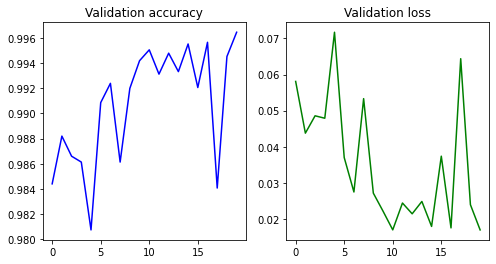

In [33]:
plot_acc_loss(valid_acc_list_rv2,valid_loss_list_rv2)

## About learning rate decay

I haven't used a learning rate scheduler for Adamax, because of this post:
https://stackoverflow.com/questions/39517431/should-we-do-learning-rate-decay-for-adam-optimizer

I'm afraid if I experimented with this, I would run out of time and it won't be worth it.

# ResNetV2 with leaky ReLU

In [37]:
class BasicBlock(nn.Module):

    def __init__(self, in_channel_size = 16, out_channel_size = 16, downsample = False):
        super().__init__()
        self.conv1 = nn.Conv2d(
                        in_channels = in_channel_size,
                        out_channels = out_channel_size,
                        kernel_size = 3,
                        stride = 2 if downsample else 1,
                        padding = 1
                        )
        self.bn1 = nn.BatchNorm2d(num_features = in_channel_size)
        self.relu1 = nn.LeakyReLU(0.1)

        self.conv2 = nn.Conv2d(
                        in_channels = out_channel_size,
                        out_channels = out_channel_size,
                        kernel_size = 3,
                        stride = 1,
                        padding = 1
                        )
        self.bn2 = nn.BatchNorm2d(num_features = out_channel_size)
        self.relu2 = nn.LeakyReLU(0.1)
        
        if downsample:
            downsample_fn = nn.AvgPool2d(kernel_size = 1, stride = 2)
            def shortcut(x): # <----------------------------------------------------------- filling tensor with zeros for increasing dimensions
                y = downsample_fn(x)
                zeros = torch.zeros_like(y)
                return torch.cat([y, zeros], axis = 1)
            self.skip_connection = shortcut
        else:
            self.skip_connection = nn.Identity() # <--------------------------------------- identity skip connection for unchanged dimensions
    
    def forward(self, x):

        y = self.bn1(x)
        y = self.relu1(y)
        y = self.conv1(y)
        y = self.bn2(y)
        y = self.relu2(y)
        y = self.conv2(y)
        
        
        y = y + self.skip_connection(x) # <--------------------------------------- skip connection
        return y

In [38]:
class ResBlock(nn.Module):

    def __init__(self, size, in_channel_size = 16, out_channel_size = 16):
        assert size % 2 == 0, f'Size must be even, not {size}'
        n = int(size / 2)
        downsample = (out_channel_size == 2 * in_channel_size)
        #print(downsample)
        if not downsample:
            assert in_channel_size == out_channel_size, 'Channel size must either be constant or doubled.'

        super().__init__()

        layers = []
        for i in range(n):
            layers.append(BasicBlock(
                            in_channel_size = in_channel_size if i == 0 else out_channel_size,
                            out_channel_size = out_channel_size,
                            downsample = downsample and i == 0
                        )
            )
        self.res_block = nn.Sequential(*layers)
    
    def forward(self, x):
        y = self.res_block(x)
        return y

class ResNetV2l(nn.Module):
    def __init__(self, size, channel_sizes = [16, 32, 64], output_size = 10):
        assert len(channel_sizes) == 3, 'Channel sizes should change two times.'
        assert size % 3 == 2, f'Size {size} is not of shape 3n + 2.'
        m = int((size - 2) / 3)

        super().__init__()
        
        self.first_layer = nn.Conv2d(
                                in_channels = 1,
                                out_channels = 16,
                                kernel_size = 3,
                                stride = 1,
                                padding = 'same'
                                )
        self.bn1 = nn.BatchNorm2d(num_features = channel_sizes[0])
        self.relu = nn.LeakyReLU(0.1)
        
        self.res_block1 = ResBlock(size = m, in_channel_size = channel_sizes[0], out_channel_size = channel_sizes[0])

        self.res_block2 = ResBlock(size = m, in_channel_size = channel_sizes[0], out_channel_size = channel_sizes[1])

        self.res_block3 = ResBlock(size = m, in_channel_size = channel_sizes[1], out_channel_size = channel_sizes[2])
        self.global_pool = nn.AdaptiveAvgPool2d(output_size = 1)
        self.final_layer = nn.Linear(in_features = channel_sizes[-1], out_features = output_size)
    
    def forward(self, x):
        
        y = self.first_layer(x)
        y = self.res_block1(y)
        y = self.res_block2(y)
        y = self.res_block3(y)
        y = self.global_pool(y)
        y = y.squeeze()

        y = self.final_layer(y)
        return y

In [46]:
torch.manual_seed(42)
model_resnetv2l_32 = ResNetV2l(20).to(device)
optimizer = optim.Adam(model_resnetv2l_32.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()

In [47]:
# https://discuss.pytorch.org/t/how-to-do-exponential-learning-rate-decay-in-pytorch/63146
decayRate = 0.96
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

In [48]:
summary(model_resnetv2l_32, input_size = (1, 28, 28), device = 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
         LeakyReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]           2,320
       BatchNorm2d-5           [-1, 16, 28, 28]              32
         LeakyReLU-6           [-1, 16, 28, 28]               0
            Conv2d-7           [-1, 16, 28, 28]           2,320
          Identity-8           [-1, 16, 28, 28]               0
        BasicBlock-9           [-1, 16, 28, 28]               0
      BatchNorm2d-10           [-1, 16, 28, 28]              32
        LeakyReLU-11           [-1, 16, 28, 28]               0
           Conv2d-12           [-1, 16, 28, 28]           2,320
      BatchNorm2d-13           [-1, 16, 28, 28]              32
        LeakyReLU-14           [-1, 16,

In [ ]:
train_loss_list_rv2l, train_acc_list_rv2l, valid_loss_list_rv2l, valid_acc_list_rv2l = train(train_loader,valid_loader,model_resnetv2l_32,optimizer,criterion,40,lr_scheduler)

[1/40] | TE: 0.153877 TA: 0.950333 | VE 0.182232 VA: 0.940333
[2/40] | TE: 0.035124 TA: 0.989111 | VE 0.055276 VA: 0.984333


In [ ]:
plot_acc_loss(valid_acc_list_rv2,valid_loss_list_rv2)

# Submission

In [ ]:
test_data = pd.read_csv('./kaggle/input/Kannada-MNIST/test.csv')
#test_data = pd.read_csv('/kaggle/input/Kannada-MNIST/test.csv')

In [ ]:
ids, test_set = test_data.id, test_data.drop(['id'], axis=1)

In [ ]:
test_set = torch.from_numpy(test_set.values)
test_set = test_set.view(test_set.shape[0],28,28).to(device)

In [ ]:
test_set.shape

In [ ]:
test_set.max()

In [ ]:
test_set = test_set/255.

In [ ]:
predictions=[]
with torch.no_grad():
    for i, data in enumerate(test_set):
        images = data.to(device)
        outputs = net(images.float().unsqueeze(0).unsqueeze(0))
        _, predicted = torch.max(outputs.data, 1)
        #print(f"{outputs.data} \n ---> {predicted} \n----------------")
        predictions.append([i,predicted.item()])

In [ ]:
predicted

In [ ]:
predictions=pd.DataFrame(predictions)

In [ ]:
predictions.columns=['id','label']

In [ ]:
predictions.to_csv('./kaggle/working/submission_2.csv', index=False)

In [ ]:
torch.__version__